In [9]:
import numpy as np
import pandas as pd


Bu Hafta 5 dersinin notebooku

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Veri okuma kısmı (hazır)

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Most parts of this cell are from the above link, modified to extract only a smaller subset of the dataset so that the notebook could run on CPU for the duration of the class quickly enough...

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Load the CIFAR10 training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Reduce the size of the training set
train_size = 1000
trainset.data = trainset.data[:train_size]
trainset.targets = trainset.targets[:train_size]

# Calculate the size of the validation set as a percentage of the training set
val_size = int(0.2 * len(trainset))

# Split the training set into a new training set and a validation set
trainset, valset = torch.utils.data.random_split(trainset, [len(trainset) - val_size, val_size])

batch_size = 4 # ne kadar büyük o kadar iyi

# Create the data loaders for the new training set, validation set, and test set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Verilerin bir kısmını görselleyelim (hazır)

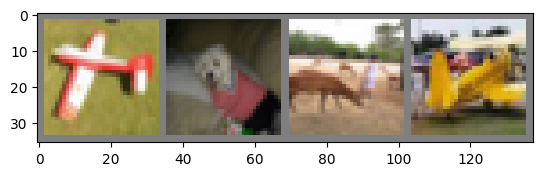

plane dog   deer  plane


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [13]:
images

tensor([[[[ 0.8353,  0.8431,  0.8510,  ...,  0.8196,  0.8510,  0.8431],
          [ 0.8275,  0.8353,  0.8431,  ...,  0.7098,  0.7333,  0.7961],
          [ 0.8196,  0.8275,  0.8353,  ...,  0.8510,  0.7647,  0.7020],
          ...,
          [-0.1373, -0.0824, -0.1294,  ...,  0.0902,  0.0902,  0.0824],
          [ 0.0039,  0.0353,  0.0118,  ...,  0.0745,  0.0745,  0.0667],
          [ 0.0275,  0.0510,  0.0824,  ...,  0.1686,  0.2235,  0.2549]],

         [[ 0.8431,  0.8510,  0.8588,  ...,  0.8275,  0.8588,  0.8510],
          [ 0.8353,  0.8431,  0.8510,  ...,  0.7176,  0.7412,  0.8039],
          [ 0.8275,  0.8353,  0.8431,  ...,  0.8588,  0.7725,  0.7098],
          ...,
          [-0.1686, -0.1529, -0.1843,  ...,  0.1059,  0.0980,  0.0824],
          [-0.0039, -0.0039, -0.0118,  ...,  0.0745,  0.0510,  0.0510],
          [ 0.0353,  0.0431,  0.0902,  ...,  0.1451,  0.2000,  0.2314]],

         [[ 0.8824,  0.8902,  0.8980,  ...,  0.8667,  0.8980,  0.8902],
          [ 0.8745,  0.8824,  

In [15]:
labels

tensor([1, 0, 1, 6])

In [14]:
len(classes)

10

# Bizim kodlarımız (our NN code)

ChatGPT: tek hidden layerlı bir multilayer perceptron oluştur, hidden layer'da tanh, output layerda softmax olsun

In [8]:
"""import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 10)

    def forward(self, x):
        x = x.view(-1, 3*32*32)
        x = self.fc1(x)
        return x"""

'import torch.nn as nn\nimport torch.nn.functional as F\n\nclass Net(nn.Module):\n    def __init__(self):\n        super(Net, self).__init__()\n        self.fc1 = nn.Linear(3*32*32, 10)\n\n    def forward(self, x):\n        x = x.view(-1, 3*32*32)\n        x = self.fc1(x)\n        return x'

Pytorch kullanmadan kod yazılabilir: ChatGPT sonucu:

In [9]:
#author of this cell: Ömer Faruk Akyapak & ChatGPT
"""import numpy as np

class MLP:
    def __init__(self, input_size, hidden_size, output_size):
        self.W1 = np.random.randn(input_size, hidden_size) / np.sqrt(input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) / np.sqrt(hidden_size)
        self.b2 = np.zeros((1, output_size))

    def tanh(self, x):
        return np.tanh(x)

    def softmax(self, x):
        exp_scores = np.exp(x)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.tanh(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.probs = self.softmax(self.z2)
        return self.probs

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

    def calculate_loss(self, X, y):
        num_examples = len(X)
        probs = self.forward(X)
        correct_logprobs = -np.log(probs[range(num_examples), y])
        data_loss = np.sum(correct_logprobs)
        return 1./num_examples * data_loss

    def train(self, X, y, num_epochs, learning_rate=0.01):
        num_examples = len(X)
        for epoch in range(num_epochs):
            # forward propagation
            self.forward(X)

            # backward propagation
            delta3 = self.probs
            delta3[range(num_examples), y] -= 1
            dW2 = (self.a1.T).dot(delta3)
            db2 = np.sum(delta3, axis=0, keepdims=True)
            delta2 = delta3.dot(self.W2.T) * (1 - np.power(self.a1, 2))
            dW1 = np.dot(X.T, delta2)
            db1 = np.sum(delta2, axis=0)

            # parameter update
            self.W1 -= learning_rate * dW1
            self.b1 -= learning_rate * db1
            self.W2 -= learning_rate * dW2
            self.b2 -= learning_rate * db2

            # print loss after every 1000 epochs
            if epoch % 1000 == 0:
                print("Epoch {0}: Loss = {1}".format(epoch, self.calculate_loss(X, y)))
"""

In [5]:
"""#Bu örnekte, girdi boyutu 10, gizli katman boyutu 5 ve çıktı boyutu 3 olsun.
#author of this cell: ilkay  biçici & ChatGPT
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden_layer = nn.Linear(10, 5)
        self.output_layer = nn.Linear(5, 3)
        self.activation = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.activation(self.hidden_layer(x))
        x = self.softmax(self.output_layer(x))
        return x

# Modeli oluştur
model = MLP()
"""

In [0]:
#Author of this cell: Ebu Belk % ChatGPT
"""import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.activation = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.activation(x)
        x = self.output_layer(x)
        x = self.softmax(x)
        return x
"""

ChatGPT'ye sor: x bir batch, içinde resim datası var, içindeki her bir resmi tek bir vektöre dönüştür pytorch ile

In [6]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, num_input_feats, num_hidden_neuron, num_classes):
        super(MLP, self).__init__()
        self.hidden_layer = nn.Linear(num_input_feats, num_hidden_neuron)
        self.output_layer = nn.Linear(num_hidden_neuron, num_classes)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # flatten the images

        #x = torch.randn(32, 3, 224, 224)  # Örnek bir tensör

        # Tensörü düzleştir
        #x = x.view(x.size(0), -1)  # -1, boyutu otomatik olarak hesaplamak için kullanılır
        # By Dr. Ulya Bayram: arkadaşlar, kodun çalışmamasının sebebi view işini düzgün yapmamamız
        # en kolayı, ben flatten fonksiyonunu kullandım onun yerine ve aşağıda training yapan cell'in output'unda
        # göreceğiniz gibi, loss değerleri gayet normal şekilde azalıyor her epoch'ta şu anda.
        x = torch.flatten(x, 1)#x.view(-1, images.size(1)*images.size(2)*images.size(3))

        # x'in boyutu (32, 150528) olacaktır

        hidden_res = self.tanh(self.hidden_layer(x))
        output = self.softmax(self.output_layer(hidden_res))
        return output

In [3]:
'''import torch

batch_size = 32
channel = 3
height = 64
width = 64

# Batch'i oluştur
batch = torch.randn(batch_size, channel, height, width)

# Her bir resmi tek bir vektöre dönüştür
batch = batch.view(batch_size, -1)

# Dönüştürülmüş batch boyutu
print(batch_size)'''

tensor([[ 2.8877e+00,  1.4367e+00,  9.7370e-01,  ..., -4.8026e-01,
         -7.6420e-01, -2.0131e+00],
        [-3.8939e-01,  9.6433e-02, -2.6690e+00,  ..., -2.5367e-02,
          5.0633e-01, -6.9945e-01],
        [ 1.1627e-01,  5.8588e-01,  1.2248e-03,  ...,  1.4201e-01,
         -6.5243e-01,  1.2492e-01],
        ...,
        [-9.6570e-02,  5.8592e-01,  5.5282e-01,  ...,  4.7055e-01,
         -7.9589e-01,  1.1278e+00],
        [ 3.6990e-01, -1.0109e-01, -9.2783e-02,  ..., -2.3141e-01,
          7.9000e-01,  1.1238e-01],
        [-2.8227e-01,  8.6650e-02,  4.3860e-01,  ..., -3.0678e-01,
         -8.6216e-01,  3.1797e-01]])


In [17]:
images.size()


torch.Size([4, 3, 32, 32])

In [9]:
learning_rate = 0.01
num_epochs = 25

# class MLP için lazım olan inputlar: num_input_feats, num_hidden_neuron, num_classes

num_input_feats = images.size(1)*images.size(2)*images.size(3) # image'ın boyutu ve kaç channel olduğu

num_hidden_neuron = 5000
num_classes = len(classes)

model = MLP(num_input_feats, num_hidden_neuron, num_classes)

# Loss function ve optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


# Train the model
for epoch in range(num_epochs):

    # training loop
    train_loss = 0.0
    train_count = 0.0
    for inputs, labels in trainloader:

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_count += 1.0
        train_loss += loss.item()
        """train_count += labels.size(0) # bu comment outlu kısmı bir arkadaş eklemiş ama gereksiz extra iş yapıyor.
        train_loss += loss.item() * labels.size(0) # batch'leri hesaba katmıyor, herşeyi 4'le (batch sayısı) çarpıyor.
        # loss değeri zaten tüm batch için toplanmış sonuç. yani içinde 4 resmin loss'u var toplam. o yüzden 4'le çarpmaya gerek yok.MLP
        # aynı şekilde count'a da 4 eklemeye gerek yok. batch sayısı ve batch loss'u üzerinde çalışmak bize yeter.
        # o yüzden train_count and train_loss kısmını eski haline getirdim"""

    print("Epoch", epoch, "Training loss", train_loss/train_count)

        

print('Finished Training')

Epoch 0 Training loss 2.2551620894670488
Epoch 1 Training loss 2.1825636720657347
Epoch 2 Training loss 2.1424230390787127
Epoch 3 Training loss 2.114121699929237
Epoch 4 Training loss 2.088930774331093
Epoch 5 Training loss 2.066676104068756
Epoch 6 Training loss 2.0482831728458404
Epoch 7 Training loss 2.0314973974227906
Epoch 8 Training loss 2.017123677134514
Epoch 9 Training loss 2.001831067800522
Epoch 10 Training loss 1.9886625641584397
Epoch 11 Training loss 1.973997032046318
Epoch 12 Training loss 1.9624252068996428
Epoch 13 Training loss 1.9500151288509369
Epoch 14 Training loss 1.9406778103113174
Epoch 15 Training loss 1.9297316205501556
Epoch 16 Training loss 1.9200841146707535
Epoch 17 Training loss 1.9125535607337951
Epoch 18 Training loss 1.9035962837934495
Epoch 19 Training loss 1.8949009102582932
Epoch 20 Training loss 1.8858156144618987
Epoch 21 Training loss 1.8793197637796402
Epoch 22 Training loss 1.8706643944978714
Epoch 23 Training loss 1.863980872631073
Epoch 24 

In [13]:
"""# Veri setini oluştur
X, y = make_classification(n_samples=1000, n_classes=3, n_features=10, n_informative=5, n_redundant=0, random_state=42)

# Veri setini eğitim ve test kümelerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeli oluştur
model = keras.models.Sequential([
    keras.layers.Dense(10, input_shape=(10,), activation="tanh"),
    keras.layers.Dense(3, activation="softmax")
])

# Modeli derle
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Modeli eğit
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Test verileri üzerinde modeli değerlendir
test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy:", test_acc)


"""

NameError: name 'make_classification' is not defined

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=700e962d-3fcf-4c82-8c8d-f1f2cc26fdf7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>